In [4]:
!pip install trdg

In [24]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 442.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 7.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 7.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 9.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00


In [25]:
import os
import random
from trdg.generators import GeneratorFromStrings
import matplotlib.pyplot as plt

In [26]:
# Пути к файлам
fonts_list_file = 'text/okfonts_test.txt'
fonts_dir = '.'
output_folder = './generated_data'
text_file = 'text/sah.training_text'

font_paths = []

In [27]:
# Загрузка списка директорий шрифтов из файла fonts_list_file
with open(fonts_list_file, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]

# Проходим по каждой директории и собираем файлы шрифтов
for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(fonts_dir, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    # Рекурсивно ищем файлы шрифтов в директории font_dir_path
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                font_paths.append(font_path)

# Вывод количества найденных шрифтов
print(f"Количество найденных файлов шрифтов: {len(font_paths)}")

Количество найденных файлов шрифтов: 75


In [30]:
with open('text/sah.training_text', 'r', encoding='utf-8') as f:
    lines = f.read().splitlines()
    
print(f"Количество строк для генерации: {len(lines)}")

Количество строк для генерации: 21757


In [31]:
random.shuffle(lines)

In [43]:
# Настройка генератора TRDG
generator = GeneratorFromStrings(
    strings=lines,
    count=len(lines),        # Количество изображений для генерации
    fonts=font_paths,
    size=32,                  # Размер шрифта (можете настроить под свои нужды)
    background_type=0,        # Тип фона: 0 - однородный, 1 - шум, 2 - градиент
    image_mode='RGB',         # Режим изображения
    text_color='black',       # Цвет текста
    skewing_angle=0,          # Максимальный угол наклона текста
    random_skew=False,         # Случайный наклон текста
    blur=0,                   # Максимальный уровень размытия
    random_blur=False,         # Случайное размытие
    is_handwritten=False,     # Генерировать рукописный текст
    alignment=1,              # Выравнивание текста: 0 - слева, 1 - по центру, 2 - справа
    width=1200,                # Ширина изображения
    fit=True,                 # Подгонка текста по ширине изображения
    space_width=1.0,          # Коэффициент ширины пробела
    character_spacing=0,      # Расстояние между символами
    stroke_width=0,           # Ширина обводки символов
    stroke_fill='#ffffff'     # Цвет обводки (если используется)
)

In [44]:
print("Генерация изображений...")
labels = []

for idx, (img, lbl) in enumerate(generator):
    # Имя файла: индекс.jpg
    image_filename = f"{idx}.jpg"
    image_path = os.path.join(output_folder, image_filename)
    img.save(image_path)
    labels.append((image_filename, lbl))
    
    # Вывод прогресса каждые 100 изображений
    if (idx + 1) % 100 == 0:
        print(f"Сгенерировано {idx + 1} изображений...")

print("Генерация завершена.")
print(f"Всего сгенерировано {len(labels)} изображений.")

Генерация изображений...
Сгенерировано 100 изображений...
Сгенерировано 200 изображений...
Сгенерировано 300 изображений...
Сгенерировано 400 изображений...
Сгенерировано 500 изображений...
Сгенерировано 600 изображений...
Сгенерировано 700 изображений...
Сгенерировано 800 изображений...
Сгенерировано 900 изображений...
Сгенерировано 1000 изображений...
Сгенерировано 1100 изображений...
Сгенерировано 1200 изображений...
Сгенерировано 1300 изображений...
Сгенерировано 1400 изображений...
Сгенерировано 1500 изображений...
Сгенерировано 1600 изображений...
Сгенерировано 1700 изображений...
Сгенерировано 1800 изображений...
Сгенерировано 1900 изображений...
Сгенерировано 2000 изображений...
Сгенерировано 2100 изображений...
Сгенерировано 2200 изображений...
Сгенерировано 2300 изображений...
Сгенерировано 2400 изображений...
Сгенерировано 2500 изображений...
Сгенерировано 2600 изображений...
Сгенерировано 2700 изображений...
Сгенерировано 2800 изображений...
Сгенерировано 2900 изображений..

In [45]:
labels_file = os.path.join(output_folder, 'labels.txt')
with open(labels_file, 'w', encoding='utf-8') as f:
    for image_filename, lbl in labels:
        f.write(f"{image_filename}\t{lbl}\n")

print(f"Файл меток сохранен: {labels_file}")

Файл меток сохранен: ./generated_data/labels.txt


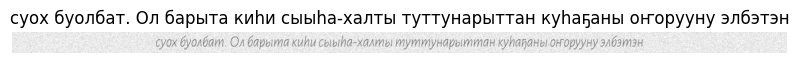

In [47]:
# Отображение примера сгенерированного изображения
sample_image_path = os.path.join(output_folder, '0.jpg')
if os.path.exists(sample_image_path):
    img = plt.imread(sample_image_path)
    plt.figure(figsize=(10, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{labels[0][1]}")
    plt.show()
else:
    print(f"Сгенерированное изображение {sample_image_path} не найдено.")